In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import zipfile
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from sklearn.model_selection import train_test_split

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [4]:
dc = os.listdir('./train')
print(dc[0])
len(dc)

dog.7376.jpg


25000

In [5]:
os.listdir("./train")[10]

'cat.3064.jpg'

In [6]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

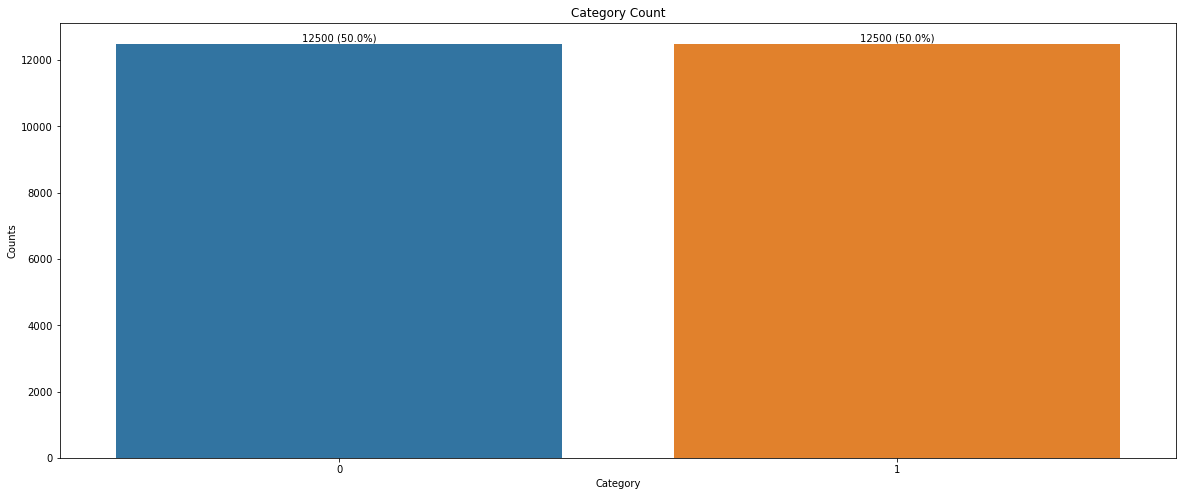

In [7]:
df_count_by_category = df['category'].value_counts().reset_index()

plt.figure(figsize=(20,8))
ax = sns.barplot(x='index', y='category', data=df_count_by_category)

for i in ax.patches:
    v1 = round((i.get_height()/len(df))*100, 2)
    ax.annotate(f'{int(i.get_height())} ({v1}%)', (i.get_x()+0.4, i.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

plt.title("Category Count")
plt.ylabel("Counts")
plt.xlabel("Category")
plt.show()

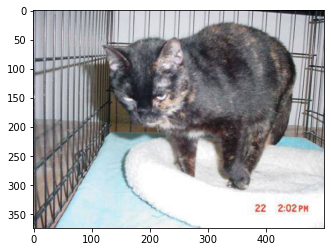

In [8]:
image = load_img('./train/'+df.iloc[44]['filename'])
plt.imshow(image)

In [9]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(2, activation = "softmax"))
#model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

In [12]:
#model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adamax' ,
                loss = 'categorical_crossentropy' ,
                metrics = ['accuracy'])

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [18]:
# Set a learning rate annealer
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

In [19]:
history = model.fit_generator(
    train_generator, 
    epochs=30,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[lr_reduction, es]
)

Train for 1333 steps, validate for 333 steps
Epoch 1/30
1333/1333 [==============================] - 269s 202ms/step - loss: 0.8188 - accuracy: 0.5807 - val_loss: 0.6757 - val_accuracy: 0.6136
Epoch 2/30
1333/1333 [==============================] - 257s 193ms/step - loss: 0.6551 - accuracy: 0.6513 - val_loss: 0.6394 - val_accuracy: 0.6523
Epoch 3/30
1333/1333 [==============================] - 256s 192ms/step - loss: 0.6073 - accuracy: 0.6815 - val_loss: 1.2085 - val_accuracy: 0.5952
Epoch 4/30
1333/1333 [==============================] - 255s 191ms/step - loss: 0.5463 - accuracy: 0.7266 - val_loss: 0.5732 - val_accuracy: 0.7391
Epoch 5/30
1333/1333 [==============================] - 257s 193ms/step - loss: 0.4710 - accuracy: 0.7822 - val_loss: 0.4062 - val_accuracy: 0.8236
Epoch 6/30
1333/1333 [==============================] - 258s 193ms/step - loss: 0.3882 - accuracy: 0.8293 - val_loss: 0.3247 - val_accuracy: 0.8583
Epoch 7/30
1333/1333 [==============================] - 259s 194ms/

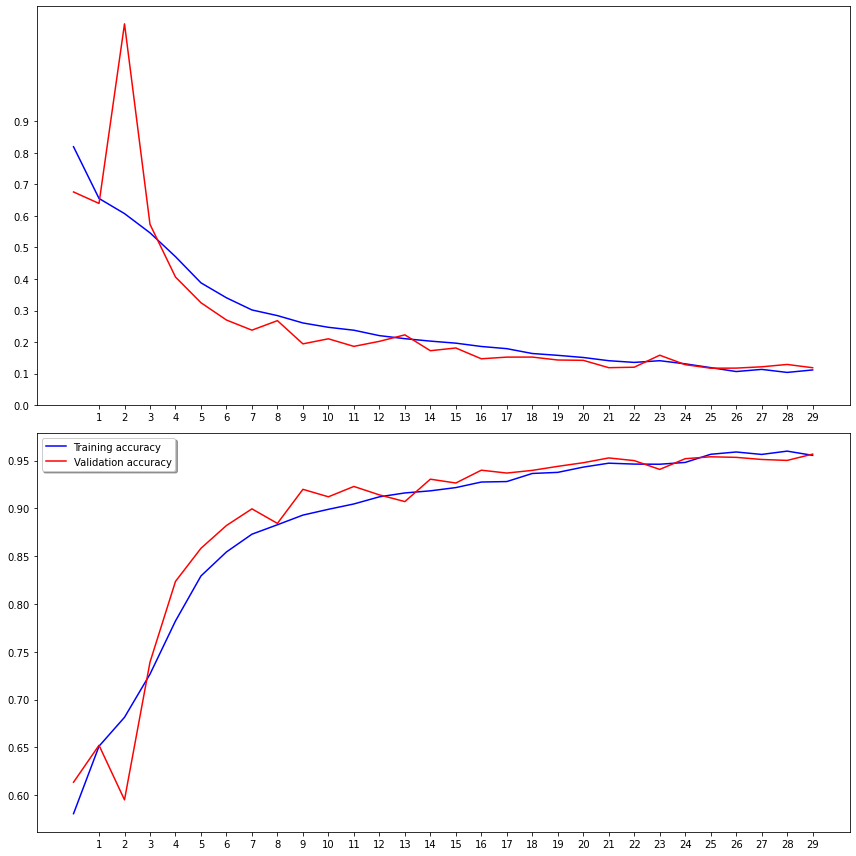

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [22]:
test_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [23]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [29]:
test_df['category'] = np.argmax(predict, axis=-1)

In [30]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [31]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [32]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_rsb_1.csv', index=False)